In [28]:
"""
Support script for countersunk fastener blog post
Eric Peters
2022-05-03
"""

# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit as cf


In [21]:
"""
define data
Source: MIL-HDBK-5J / MMPDS-01
  Protruding head: Table 8.1.4.1(a)
  CSK head: Table 8.1.4.2(c) and 8.1.4.2(a)
  Clad 7075-T6: Table 3.7.6.0(c1)

All data for DIA .250 fasteners
"""

# thickness, in
t = np.array([.080, .090, .100, .125, .160, .190, .250])

# nominal shank diameter, in
D = 0.250

# countersink head height, in
t_csk = 0.060

# Fastener ultimate shear strength @ shank, lbf
Psu = 4660

# Joint ultimate strength CASR925 protruding shear head, lbf
Pult_prot = np.array([2415, 2688, 2960, 3641, 4595, 4660, 4660])

# Joint ultimate strength, CSR924 100* flush shear head, lbf
Pult_csk = np.array([2281, 2594, 2919, 3765, 4387, 4525, 4660])

# Ultimate bearing strength, Clad 7075-T6, e/D = 2.0, A-basis, psi
Fbru_2A = 140000
# Ultimate bearing strength, Clad 7075-T6, e/D = 2.0, B-basis, psi
Fbru_2B = 154000

In [83]:
# Maths

# thickness at which bearing strength equals fastener shear strength, in
teq_A = Psu/(Fbru_2A*D)
teq_B = Psu/(Fbru_2B*D)

tbru_A = np.array([0,teq_A, 1.5*max(t)])
tbru_B = np.array([0,teq_B, 1.5*max(t)])
Pbru_2A = np.array([0, Psu, Psu])
Pbru_2B = np.array([0, Psu, Psu])

# curve fit the csk data using scipy.optimize.cf
# define a curve function
def x3(x, *params):
  a, b, c, d = params
  return a*x**3 + b*x**2 + c*x + d

popt, pcov = cf(x3, t, Pult_csk, p0=[1,1,1,1])

# curve fit the csk data using numpy.polyfit
p3opt = np.polyfit(t, Pult_csk,3) 
p6opt = np.polyfit(t, Pult_csk,6)
x3fit = np.poly1d(p3opt)
x6fit = np.poly1d(p6opt)
tfit = np.arange(min(t),max(t),step=0.005)


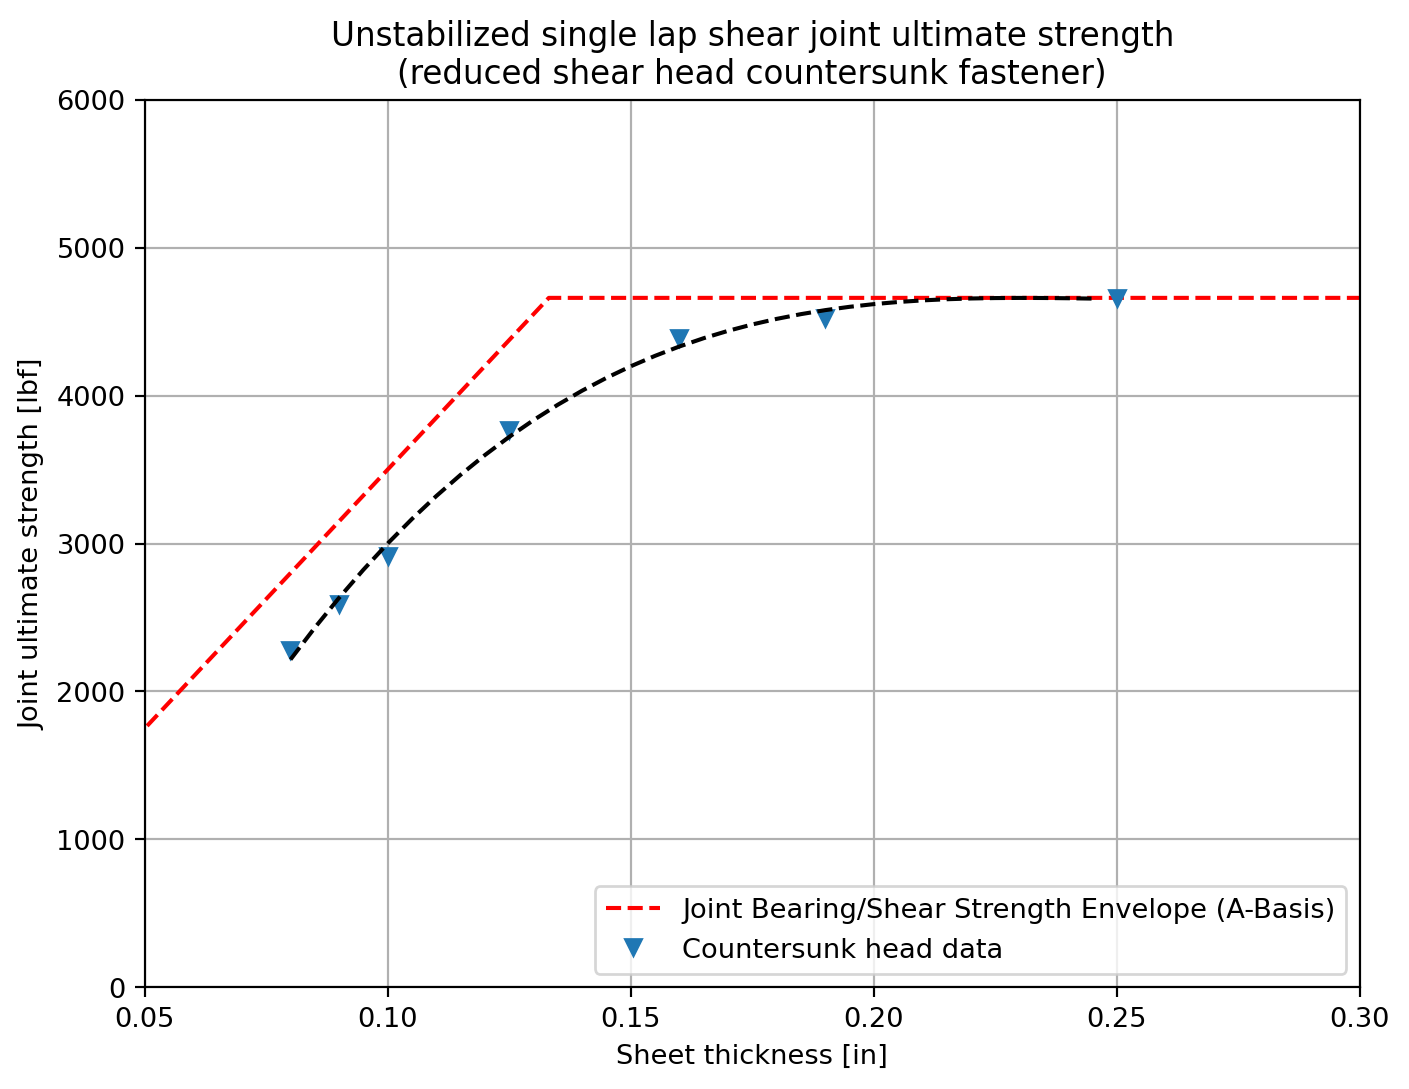

In [84]:
# Plots!

plt.figure(num=1,dpi=196, figsize=(8,6))
plt.title('Unstabilized single lap shear joint ultimate strength\n(reduced shear head countersunk fastener)')
plt.xlabel('Sheet thickness [in]')
plt.ylabel('Joint ultimate strength [lbf]')
plt.xlim((0.050, 0.3))
plt.ylim((0,6000))
plt.plot(tbru_A,Pbru_2A,'--r', label='Joint Bearing/Shear Strength Envelope (A-Basis)')
#plt.plot(tbru_B,Pbru_2B,'--b', label='Joint Bearing/Shear Strength Envelope (B-Basis)')
#plt.plot(t,Pult_prot,'o', label='Protruding shear head data')
plt.plot(t,Pult_csk,'v', label='Countersunk head data')
#plt.plot(t,Pult_csk/0.85,'v', label='Countersunk head (TYP estimate)')
plt.plot(tfit,x3fit(tfit),'--k')
plt.legend(loc=4)
plt.grid(visible=True, which='both', axis='both')

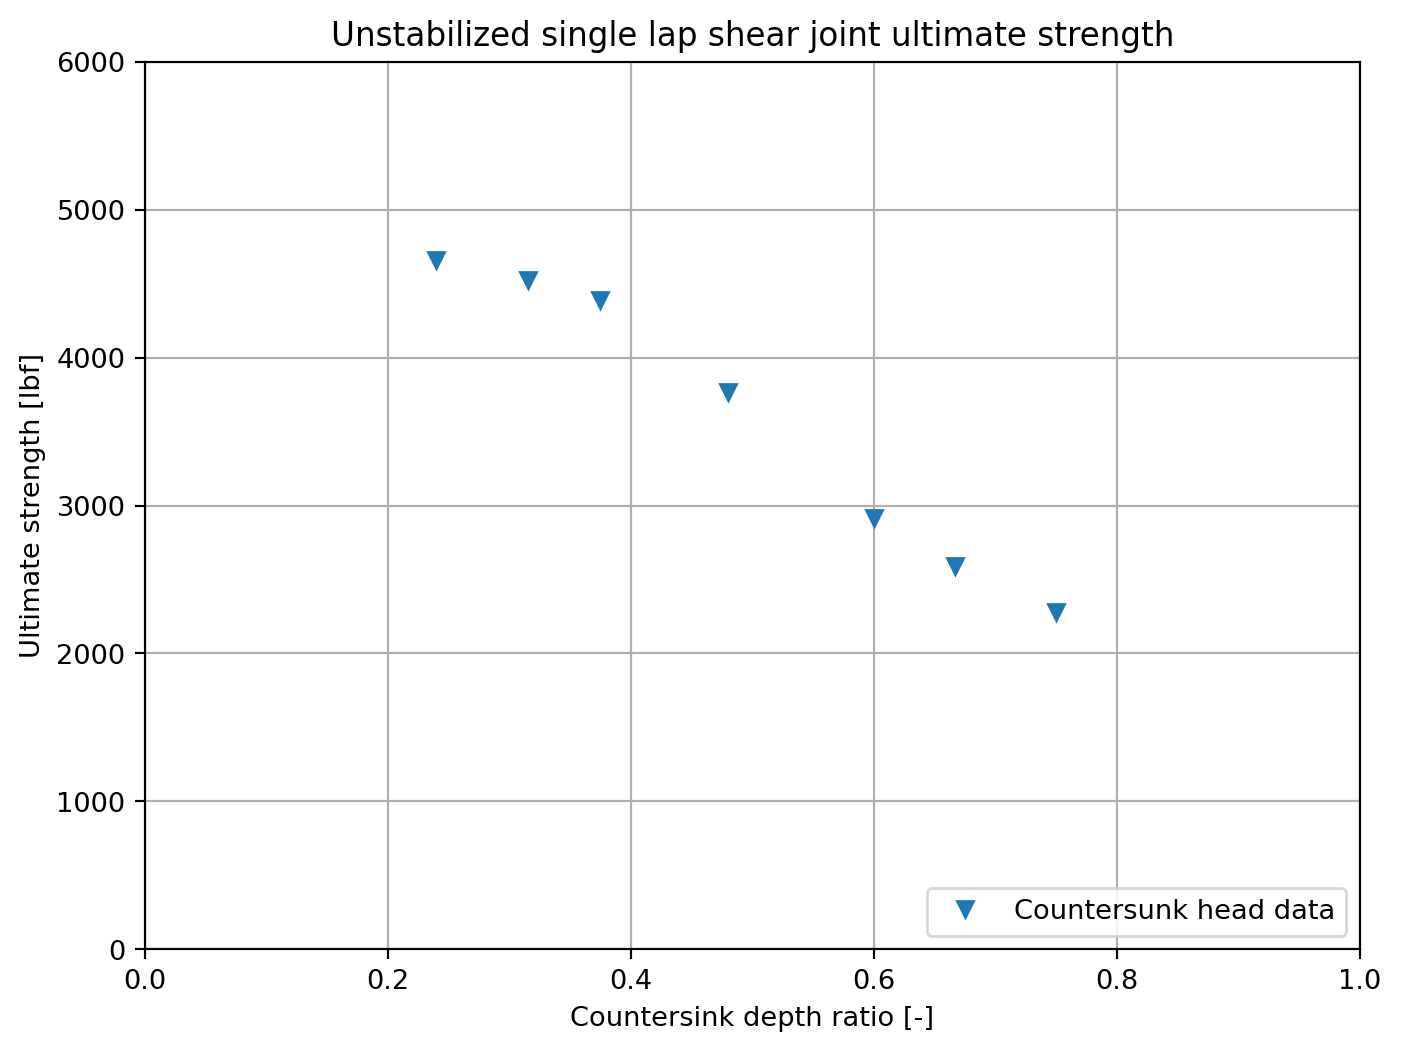

In [86]:
plt.figure(num=2,dpi=196, figsize=(8,6))
plt.title('Unstabilized single lap shear joint ultimate strength')
plt.xlabel('Countersink depth ratio [-]')
plt.ylabel('Ultimate strength [lbf]')
plt.xlim((0,1))
plt.ylim((0,6000))
#plt.plot(t_csk/tbru_A,Pbru_2A,'--r', label='Joint Bearing/Shear Strength Envelope')
#plt.plot(t,Pult_prot,'o', label='Protruding shear head data')
plt.plot(t_csk/t,Pult_csk,'v', label='Countersunk head data')
plt.legend(loc=4)
plt.grid(visible=True, which='both', axis='both')